## **REGRESSION MODELS**

In [1]:
# I checked warnings, but for the final report I prefer ignore those 
#that really does not affect the results (warnings of libraries, etc)
import warnings
warnings.simplefilter('ignore')

In [2]:
## **LOAD PACKAGES**

import pandas as pd
import os
from datetime import datetime
import numpy as np

#Sometimes I will use R functions (those I believe are the best ones)
# Load in the r magic
%load_ext rpy2.ipython

In [3]:
# Sometimes I will use R functions (those I believe are the best ones)
# Load in the r magic
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(dplyr)
%R require(data.table)
%R require(cowplot)

# own functions 
%R source('utils/Rgraphs.R')

R[write to console]: Loading required package: ggplot2



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: data.table

R[write to console]: 
Attaching package: ‘data.table’


R[write to console]: The following objects are masked from ‘package:dplyr’:

    between, first, last


R[write to console]: Loading required package: cowplot

R[write to console]: 
Attaching package: ‘cowplot’


R[write to console]: The following object is masked from ‘package:ggplot2’:

    ggsave




R object with classes: ('list',) mapped to:
[SexpClosure, BoolSexpVector]
  value: <class 'rpy2.rinterface.SexpClosure'>
  <rpy2.rinterface.SexpClosure object at 0x7f36e2dbf5f0> [RTYPES.CLOSXP]
  visible: <class 'rpy2.rinterface.BoolSexpVector'>
  <rpy2.rinterface.BoolSexpVector object at 0x7f36e2dbfa00> [RTYPES.LGLSXP]

In [4]:
#load treated and aggregated datas
df = pd.read_csv('data/eng_data.csv') 
df_topic = pd.read_csv('data/topic_data.csv') 

In [5]:
df = pd.merge(df, df_topic, on = 'url_title', how = 'left')
print(df.shape)
df = df.select_dtypes(include=[np.int, np.float])
print(df.shape)

(9860, 21)
(9860, 17)


In [6]:
pd.set_option('display.max_rows', 500)
df.dtypes

Sessions             float64
Avg. Time on Page      int64
Bounce Rate          float64
Page Views           float64
Unique Page Views    float64
Users                float64
content_length         int64
month                  int64
mobile                 int64
tablet                 int64
(direct)               int64
goog                   int64
nkedin                 int64
t.co                   int64
spain                  int64
united states          int64
Topic                float64
dtype: object

In [7]:
# result can be used w/ seaborn's heatmap
def compute_correlation_matrix(df, method='pearson'):
    import pandas as pd
    corr_mat = df.corr()
    return corr_mat

import matplotlib.pyplot as plt
import seaborn as sns
cr = compute_correlation_matrix(df)
fig, ax = plt.subplots(figsize=(15,15))
b = sns.heatmap(cr,  vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", annot_kws={"size": 12}, ax= ax, cmap="RdBu_r")
b.tick_params(labelsize=15)
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5]),
 <a list of 17 Text xticklabel objects>)

In [8]:
#topics in other languages
df["Topic"] = pd.to_numeric(df.Topic, errors='coerce').fillna(7).astype(int)
#one hot encoding of topic
df_topic = pd.get_dummies(df['Topic'],drop_first=True, prefix='Topic')
# concatenate data.frames
frames = [df, df_topic]
df = pd.concat(frames, axis = 1) #, sort= True
df = df.drop(columns = ['Topic'])

In [9]:
## eliminate correlated columns
df = df.drop(columns = ['Unique Page Views', 'Users'])

## **LOG TRANSFORMATION**

In [10]:
#log transformations
df['Avg_Time_Page'] = df['Avg. Time on Page']
df['log_Avg_Time_Page'] = np.log(df['Avg_Time_Page'] + 10)
df = df.drop(columns = ['Avg_Time_Page', 'Avg. Time on Page'])

In [11]:
df['log_Avg_Time_Page'].describe()

count    9860.000000
mean        3.257845
std         1.376562
min         2.302585
25%         2.302585
50%         2.302585
75%         4.143135
max         7.501082
Name: log_Avg_Time_Page, dtype: float64

## CORRELATIONS: CONTINOUS VARIABLES + ITERACTIONS



* We will explore interactions between continuous variables, in order to see if we can get more information, that help us to improve our predictions.

* We well see which variables have high correlation with the variable we want to predict
* We want to avoid multicolineallity, for this we eliminate those explanatory variables that have high correlations between them.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5]),
 <a list of 21 Text xticklabel objects>)

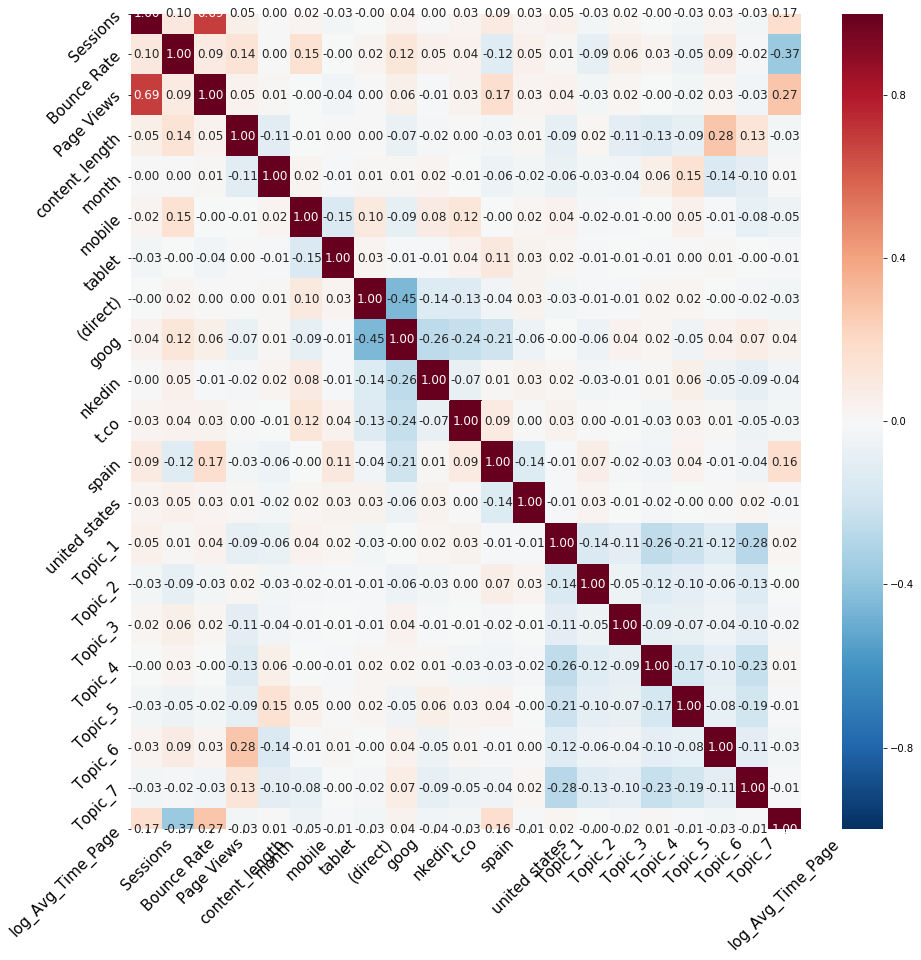

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
cr = compute_correlation_matrix(df)
fig, ax = plt.subplots(figsize=(15,15))
b = sns.heatmap(cr,  vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", annot_kws={"size": 12}, ax= ax, cmap="RdBu_r")
b.tick_params(labelsize=15)
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 

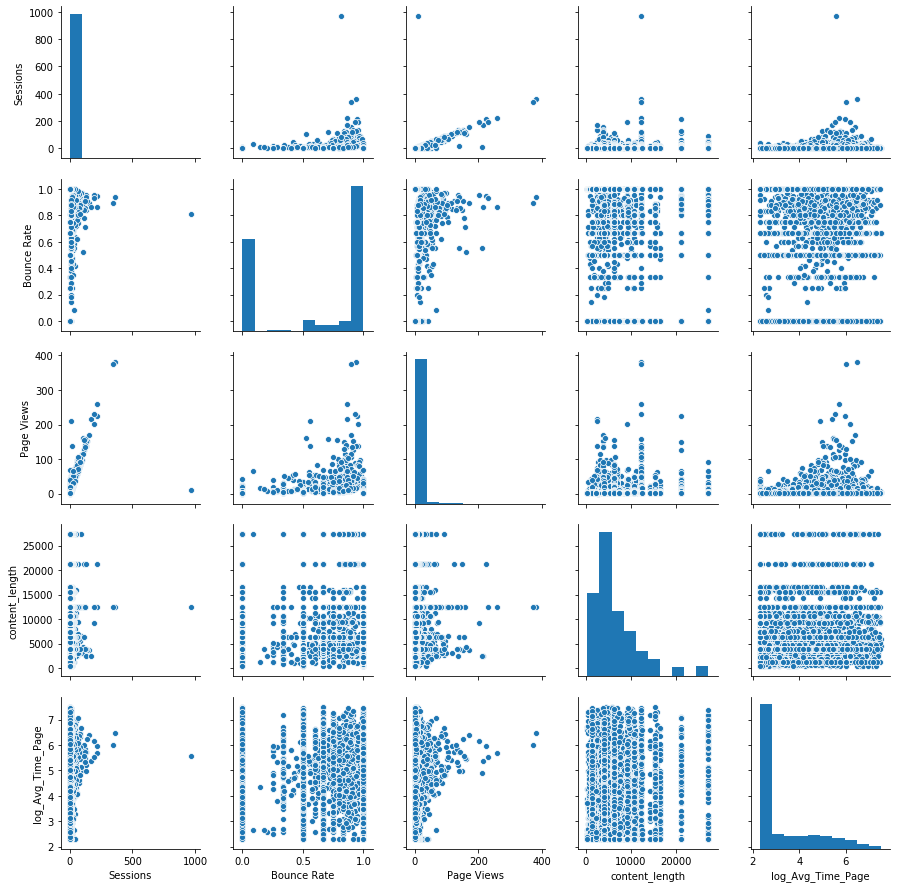

In [13]:
# numerical variables
columns = ['Sessions', 'Bounce Rate', 'Page Views', 'content_length', 'log_Avg_Time_Page']
sns.pairplot(df[columns])#

## **OTHER ALTERNATIVES OF FEATUREING SELECTION**

we can also measure the **MUTUAL INFORMATION** information that exists between the variables and the target (poor/not poor) to select the variables. 

In [14]:
from sklearn.feature_selection import mutual_info_regression
#from sklearn.feature_extraction.text import get_feature_names
Y = df['log_Avg_Time_Page']
X = df.drop(columns = 'log_Avg_Time_Page')
dx = dict(zip(X.columns, mutual_info_regression(X, Y)))
dd = pd.DataFrame(dx, index=[1]).transpose()

R[write to console]: Saving 12,5 x 6,94 in image



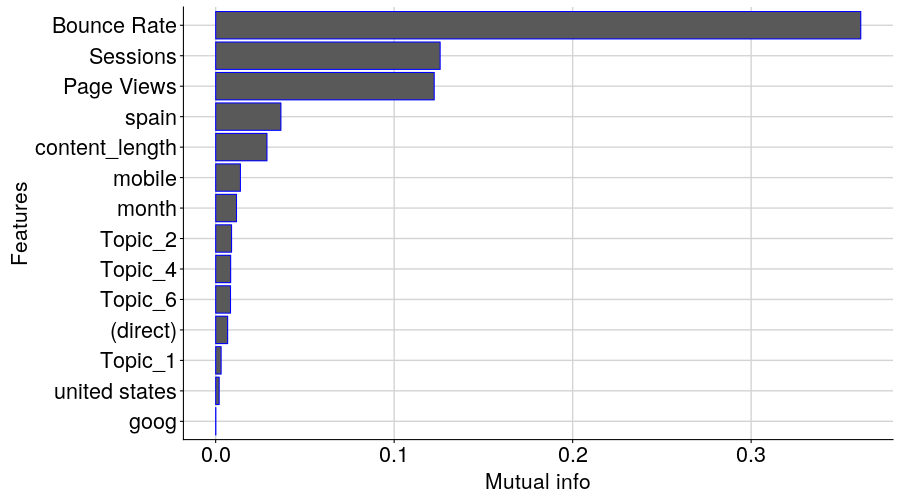

In [15]:
%%R -i dd -w 900 -h 500 -u px

d = Mutual_info(dd)
print(d)
ggsave('fig/mutual_info_classif.png')

## **DIVISION IN TRAINING AND TEST**

In [16]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)
test_y = test['log_Avg_Time_Page'] 
test = test.drop(columns = ['log_Avg_Time_Page'])

In [17]:
train.head()

Sessions  Bounce Rate  Page Views  content_length  month  mobile  \
5706       1.0          1.0         1.0            4936     11       0   
3819       0.0          0.0         1.0             686     12       0   
9550       4.0          1.0        39.0            1291      9       0   
2874       2.0          1.0         2.0            2508      3       0   
8680       0.0          0.0         1.0            9447      3       0   

      tablet  (direct)  goog  nkedin  ...  spain  united states  Topic_1  \
5706       1         0     0       1  ...      0              1        0   
3819       0         0     1       0  ...      0              0        1   
9550       0         0     1       0  ...      1              0        1   
2874       0         0     0       0  ...      0              0        0   
8680       0         0     0       1  ...      0              0        1   

      Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  log_Avg_Time_Page  
5706        0        0        0        0        0        1           2.302585  
3819        0        0        0        0        0        0           2.302585  
9550        0        0        0        0        0        0           5.468060  
2874        0        1        0        0        0        0           2.302585  
8680        0        0        0        0        0        0           3.332205  

[5 rows x 21 columns]

In [18]:
#missing
missing = (df.isnull().sum(axis = 0)/df.shape[0])*100
missing = missing.apply(pd.to_numeric)
missing= pd.DataFrame(missing)
missing.head()

0
Sessions        0.0
Bounce Rate     0.0
Page Views      0.0
content_length  0.0
month           0.0

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train, test = train_test_split(df, test_size=0.2)
# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(train)

(-2, 2)

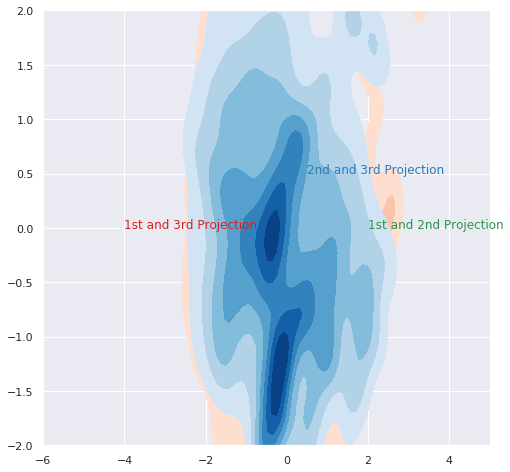

In [20]:
from sklearn.decomposition import PCA
sklearn_pca=PCA(n_components=5)
X_Train=sklearn_pca.fit_transform(X_std)

sns.set(style='darkgrid')
f, ax = plt.subplots(figsize=(8, 8))
# ax.set_aspect('equal')
ax = sns.kdeplot(X_Train[:,0], X_Train[:,1], cmap="Greens",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,1], X_Train[:,2], cmap="Reds",
          shade=True, shade_lowest=False)
ax = sns.kdeplot(X_Train[:,2], X_Train[:,3], cmap="Blues",
          shade=True, shade_lowest=False)
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.5, 0.5, "2nd and 3rd Projection", size=12, color=blue)
ax.text(-4, 0.0, "1st and 3rd Projection", size=12, color=red)
ax.text(2, 0, "1st and 2nd Projection", size=12, color=green)
plt.xlim(-6,5)
plt.ylim(-2,2)

## **REGRESSIONS**

In [21]:
y_train = train['log_Avg_Time_Page'] 
x_train = train.drop(columns = ['log_Avg_Time_Page'])
y_test  = test['log_Avg_Time_Page'] 
x_test  = test.drop(columns = ['log_Avg_Time_Page'])

y_Train=list(y_train)

In [22]:
def error_comparison(y_predict, y_Train, method = 'Ridge', data_t = 'training'):
    
    #transform
    y_predict = np.exp(y_predict) - 10
    y_Train = np.exp(y_Train) - 10
    
    
    error=0
    mae_sum = 0
    mse_sum = 0
    for i in range(len(y_Train)):
        mae_sum += abs(y_Train[i]-y_predict[i])
        error+=(abs(y_Train[i]-y_predict[i])/y_predict[i])
        mse_sum += (y_Train[i]-y_predict[i])**2
    train_error_ridge= 100 - error/len(y_Train)*100
    mae = mae_sum/len(y_Train)
    rmse = np.sqrt(mse_sum/len(y_Train))
    #print(data_t + " error = "'{}'.format(train_error_ridge)+" mape percent in " + method + " Regression")
    print(data_t + " error = "'{}'.format(mae)+" mae in " + method + "Regression")
    print(data_t + " error = "'{}'.format(rmse)+" rmse in " + method + "Regression")

    return train_error_ridge, mae, rmse

## **Modelling**

In [23]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

## **RIDGE**

In [24]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline

In [25]:
# RANDON SEARCH
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = { "fit_intercept": ["True", "False"],
                  "alpha": range(1, 15),
                  "solver": ["auto", "svd", "cholesky", "lsqr"], 
                  "normalize": ["True", "False"]
             }
ridge = linear_model.Ridge()
ridge_cv = RandomizedSearchCV(ridge, param_dist, cv=10)
X = ridge_cv.fit(x_train,y_train)

-- Random Parameter Search via 10-fold CV


In [26]:
print(ridge_cv.best_score_)
print(ridge_cv.best_params_)
print(ridge_cv.best_estimator_)

0.14169428995725586
{'solver': 'auto', 'normalize': 'True', 'fit_intercept': 'False', 'alpha': 2}
Ridge(alpha=2, copy_X=True, fit_intercept='False', max_iter=None,
      normalize='True', random_state=None, solver='auto', tol=0.001)


In [27]:
model = Pipeline([('scaler', StandardScaler()),
                  #('ridge', linear_model.Ridge(solver= "lsqr", normalize= 'True', fit_intercept= 'False', alpha= 7))
                  ('ridge', linear_model.Ridge(solver= "auto", normalize= 'True', fit_intercept= 'False', alpha= 2))
                 ])
model.fit(x_train,y_train)
y_predict=model.predict(x_train)

ridge_percent, ridge_mae, ridge_mse = error_comparison(y_predict, y_Train)

training error = 86.19211058544435 mae in RidgeRegression
training error = 243.02369056957235 rmse in RidgeRegression


[[1.         0.48002505]
 [0.48002505 1.        ]]


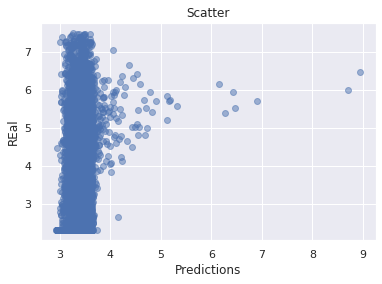

In [28]:
print(np.corrcoef(y_predict, y_Train))
# Plot
plt.scatter(y_predict, y_Train, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

In [29]:
cols = x_train.columns
coef = pd.DataFrame(model['ridge'].coef_)
coef['names'] = cols
coef.columns = ['weights', 'names']

R[write to console]: Saving 12,5 x 13,9 in image



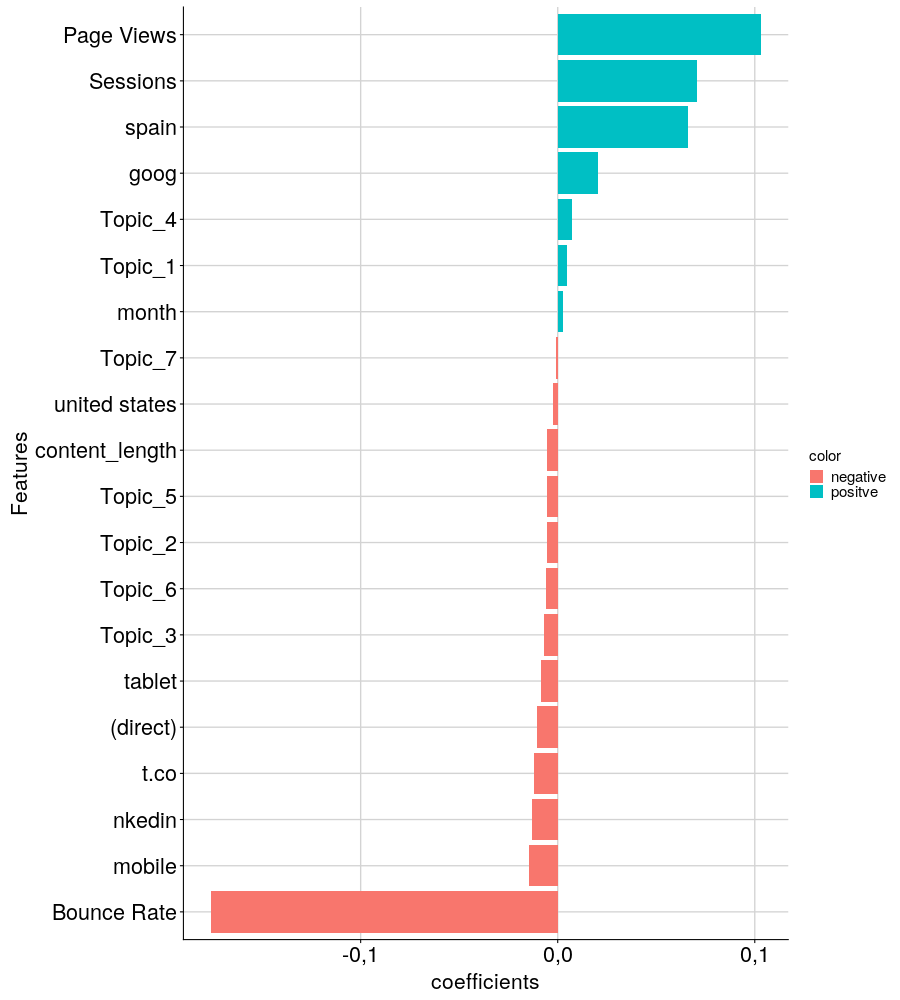

In [30]:
%%R -i coef -w 900 -h 1000 -u px

dt.values = as.data.table(coef)
names(dt.values) = c( 'value', 'Var1')
dt.values = dt.values[order(value, decreasing = T),]
dt.values = dt.values %>% mutate(color = ifelse(value <= 0,  'negative', 'positve'))

d <- ggplot(dt.values, aes(y = value, x = reorder(Var1, value), fill = color)) +  geom_bar(stat = "identity") + coord_flip()
d <- d + ylab('coefficients') + xlab('Features') 
  #d <- d +  theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(1.5)))
d <- d + theme(axis.text.y = element_text(size = rel(1.8)))
d <- d + theme(axis.text.x = element_text(size = rel(1.8)))
d <- d + theme(axis.title.x = element_text(size = rel(1.5)))
d <- d + theme(legend.text = element_text(size = 15))
d <- d + theme(legend.title = element_text(size = 15))
d <- d +  theme(
    panel.background = element_rect(fill="white") ,
    panel.grid.minor.y = element_line(size=3),
    panel.grid.major = element_line(colour = "lightgray"),
    plot.background = element_rect(fill="white")
  )

ggsave('fig/ridge_importance.png')
d

In [31]:
y_Predict=model.predict(x_test)
Y_test=list(y_test)

t_ridge_percent, t_ridge_mae, t_ridge_mse = error_comparison(y_Predict, Y_test, method = 'Ridge', data_t = 'test')

test error = 88.33146979122414 mae in RidgeRegression
test error = 548.3670725511854 rmse in RidgeRegression


[[1.         0.43299654]
 [0.43299654 1.        ]]


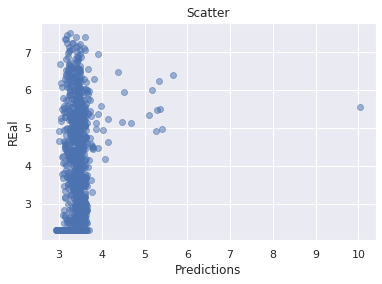

In [32]:
print(np.corrcoef(y_Predict, Y_test))
# Plot
plt.scatter(y_Predict, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Ridge Regression')

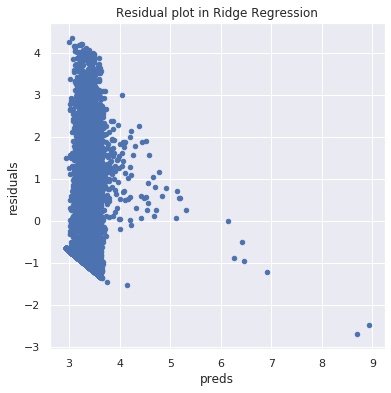

In [33]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Ridge Regression")

## **Knn Algorithm**

In [34]:
from sklearn.pipeline import Pipeline
from sklearn import neighbors

In [35]:
print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {"algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "leaf_size": randint(10, 50),
              "n_neighbors": randint(1, 5),
              "weights": ["uniform", "distance"],
              "p": randint(1, 4),
              
             }
neighbors = neighbors.KNeighborsRegressor()
neighbors_cv = RandomizedSearchCV(neighbors, param_dist, cv=10)
X = neighbors_cv.fit(x_train,y_train)


-- Random Parameter Search via 10-fold CV


In [36]:
print(neighbors_cv.best_score_)
print(neighbors_cv.best_params_)
print(neighbors_cv.best_estimator_)

0.23856352653778856
{'algorithm': 'kd_tree', 'leaf_size': 24, 'n_neighbors': 4, 'p': 3, 'weights': 'uniform'}
KNeighborsRegressor(algorithm='kd_tree', leaf_size=24, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=3,
                    weights='uniform')


In [37]:
from sklearn import neighbors
knn = Pipeline([('scaler', StandardScaler()),
                 ('knn', neighbors.KNeighborsRegressor(n_neighbors = 4,weights='uniform'))
                #('knn', neighbors.KNeighborsRegressor(n_neighbors = 4, p = 1, weights='uniform', algorithm= "ball_tree", leaf_size =  45))
               ])
knn.fit(x_train,y_train)
y1_knn=knn.predict(x_train)

knn_percent, knn_mae, knn_mse  = error_comparison(y1_knn, y_Train, method = 'Knn', data_t = 'training')

training error = 69.36699862093026 mae in KnnRegression
training error = 196.22046871058868 rmse in KnnRegression


In [38]:
y2_knn=knn.predict(x_test)
y2_knn=list(y2_knn)
t_knn_percent, t_knn_mae, t_knn_mse = error_comparison(y2_knn, Y_test, method = 'Knn', data_t = 'test')

test error = 71.58798633996854 mae in KnnRegression
test error = 195.36562990813172 rmse in KnnRegression


[[1.         0.55580717]
 [0.55580717 1.        ]]


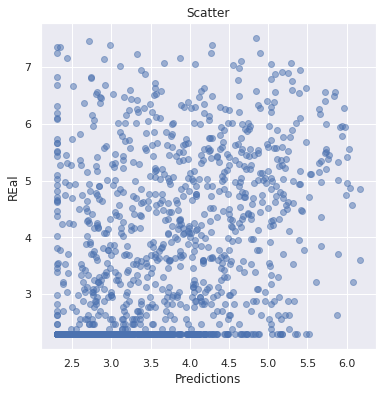

In [39]:
print(np.corrcoef(y2_knn, Y_test))
# Plot
plt.scatter(y2_knn, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Knn')

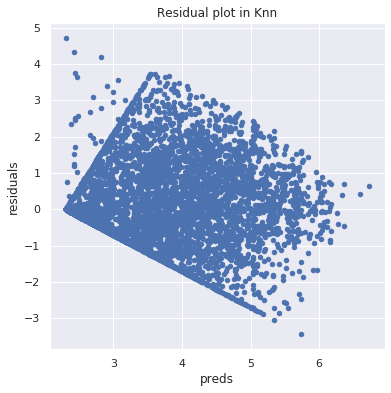

In [40]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Knn")

## **Bayesian Regression**

In [41]:
from sklearn import linear_model
from sklearn.pipeline import Pipeline

In [42]:
distribution = [i/1e5 for i in range (1,100)]

In [43]:
# RANDON SEARCH

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {"fit_intercept": [True, False],
               "normalize" : [True, False],
                  "alpha_1": distribution,
                  "alpha_2": distribution,
                  "lambda_1": distribution,
                  "lambda_2": distribution
                  
             }
bayes = linear_model.BayesianRidge()
bayes_cv = RandomizedSearchCV(bayes, param_dist, cv=10)
X = bayes_cv.fit(x_train,y_train)

-- Random Parameter Search via 10-fold CV


In [44]:
print(bayes_cv.best_score_)
print(bayes_cv.best_params_)
print(bayes_cv.best_estimator_)

0.24951029280124923
{'normalize': True, 'lambda_2': 0.00099, 'lambda_1': 0.00096, 'fit_intercept': True, 'alpha_2': 0.00028, 'alpha_1': 0.00058}
BayesianRidge(alpha_1=0.00058, alpha_2=0.00028, compute_score=False,
              copy_X=True, fit_intercept=True, lambda_1=0.00096,
              lambda_2=0.00099, n_iter=300, normalize=True, tol=0.001,
              verbose=False)


In [45]:
'''
from sklearn import linear_model
from sklearn.pipeline import Pipeline
reg = Pipeline([('scaler', StandardScaler()),
                  ('bayes', linear_model.BayesianRidge())])
reg.fit(x_train,y_train)
'''

"\nfrom sklearn import linear_model\nfrom sklearn.pipeline import Pipeline\nreg = Pipeline([('scaler', StandardScaler()),\n                  ('bayes', linear_model.BayesianRidge())])\nreg.fit(x_train,y_train)\n"

In [46]:
reg = linear_model.BayesianRidge(normalize= True, lambda_2= 0.00099, lambda_1 = 0.00096, fit_intercept = True, alpha_2 =0.00028, alpha_1= 0.00058)
reg.fit(x_train,y_train)
y1_reg=reg.predict(x_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

In [47]:
bayes_percent, bayes_mae, bayes_mse = error_comparison(y1_reg, y_Train, method = 'Bayes', data_t = 'training')

training error = 242.2497235798129 mae in BayesRegression
training error = 8266.409421207605 rmse in BayesRegression


In [48]:
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

In [49]:
t_bayes_percent, t_bayes_mae, t_bayes_mse = error_comparison(y2_reg, Y_test, method = 'Bayes', data_t = 'test')

test error = 15856.151956827787 mae in BayesRegression
test error = 700219.2525319882 rmse in BayesRegression


[[1.         0.26897786]
 [0.26897786 1.        ]]


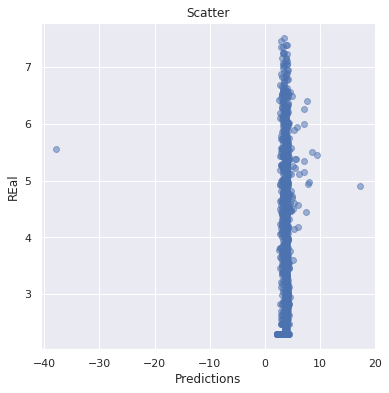

In [50]:
print(np.corrcoef(y2_reg, Y_test))
# Plot
plt.scatter(y2_reg, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Bayesian Regression')

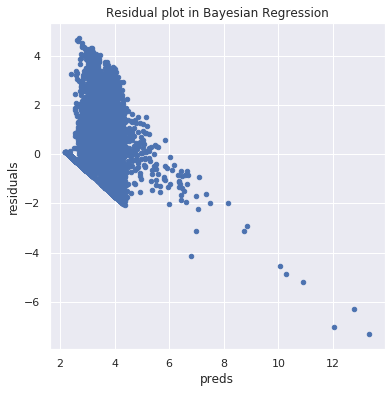

In [51]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":reg.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Bayesian Regression")

In [52]:
x_train.head()

Sessions  Bounce Rate  Page Views  content_length  month  mobile  \
284        1.0          1.0         1.0            3799     11       1   
3657       1.0          0.0         2.0            2967     10       0   
1164       1.0          1.0         1.0            4550      2       1   
7811       1.0          1.0         1.0           12373      7       0   
1780      10.0          0.8        13.0            6537      9       0   

      tablet  (direct)  goog  nkedin  t.co  spain  united states  Topic_1  \
284        0         0     1       0     0      0              0        1   
3657       0         0     1       0     0      0              0        0   
1164       0         0     0       0     0      1              0        1   
7811       0         0     1       0     0      0              0        1   
1780       0         1     0       0     0      0              0        1   

      Topic_2  Topic_3  Topic_4  Topic_5  Topic_6  Topic_7  
284         0        0        0        0        0        0  
3657        0        0        0        1        0        0  
1164        0        0        0        0        0        0  
7811        0        0        0        0        0        0  
1780        0        0        0        0        0        0

## **Decision Tree Regressor**

In [53]:
from sklearn import tree
dec = tree.DecisionTreeRegressor(max_depth=1)
dec.fit(x_train,y_train)
y1_dec=dec.predict(x_train)
y1_dec=list(y1_dec)
y2_dec=dec.predict(x_test)
y2_dec=list(y2_dec)

In [54]:
dt_percent, dt_mae, dt_mse = error_comparison(y1_dec, y_Train, method = 'Decision Tree', data_t = 'training')
t_dt_percent, t_dt_mae, t_dt_mse = error_comparison(y2_dec, Y_test, method = 'Decision', data_t = 'test')

training error = 79.7195810173326 mae in Decision TreeRegression
training error = 213.6227216741682 rmse in Decision TreeRegression
test error = 72.73598271476897 mae in DecisionRegression
test error = 198.26999147161126 rmse in DecisionRegression


[[1.         0.58514884]
 [0.58514884 1.        ]]


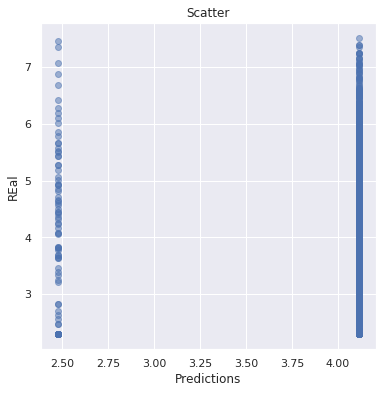

In [55]:
print(np.corrcoef(y2_dec, Y_test))
# Plot
plt.scatter(y2_dec, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in Decision Tree')

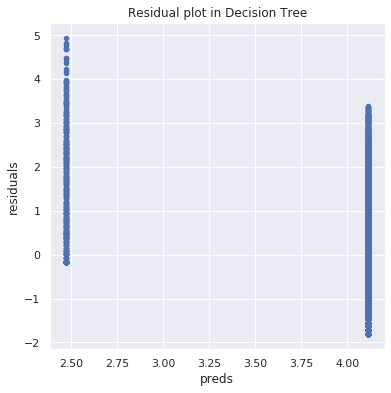

In [56]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":dec.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in Decision Tree")

## **SVM**

In [57]:
from sklearn import svm
from sklearn.pipeline import Pipeline

In [58]:

'''
# RANDON SEARCH
print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = { #"shrinking": [True, False],
               #   "C": randint(1, 5),
                  "tol": distribution  
             }
sv = svm.SVR(kernel='linear')
sv_cv = RandomizedSearchCV(sv, param_dist, cv= 5)
X = sv_cv.fit(x_train,y_train)

print(sv_cv.best_score_)
print(sv_cv.best_params_)
print(sv_cv.best_estimator_)
'''

'\n# RANDON SEARCH\nprint("-- Random Parameter Search via 10-fold CV")\n\n# dict of parameter list/distributions to sample\nparam_dist = { #"shrinking": [True, False],\n               #   "C": randint(1, 5),\n                  "tol": distribution  \n             }\nsv = svm.SVR(kernel=\'linear\')\nsv_cv = RandomizedSearchCV(sv, param_dist, cv= 5)\nX = sv_cv.fit(x_train,y_train)\n\nprint(sv_cv.best_score_)\nprint(sv_cv.best_params_)\nprint(sv_cv.best_estimator_)\n'

In [59]:
model = Pipeline([('scaler', StandardScaler()),
                  ('svr', svm.SVR(kernel='linear', max_iter = 10000,  tol=0.01))])
model.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='auto_deprecated', kernel='linear', max_iter=10000,
                     shrinking=True, tol=0.01, verbose=False))],
         verbose=False)

In [60]:
y1_svm=model.predict(x_train)
y1_svm=list(y1_svm)
y2_svm=model.predict(x_test)
y2_svm=list(y2_svm)

## **IMPORTANCE svm**

In [61]:
model.named_steps['svr'].coef_

array([[-7.60162968e-01, -5.00711672e-01,  1.44188434e+00,
         3.48870447e-02, -3.38000906e-02,  8.85406291e-02,
         5.70199757e-02,  7.63157948e-02,  1.02749842e-01,
         4.37752614e-02,  2.70371729e-02,  8.27579110e-02,
         7.46904870e-03,  2.81771561e-03, -4.88820849e-03,
         2.84775040e-03,  8.78554698e-03, -1.14619537e-03,
         1.22690079e-02,  4.38344828e-02]])

In [62]:
cols = x_train.columns
coef = pd.DataFrame(model.named_steps['svr'].coef_)
coef.columns = cols
coef = coef.transpose()

R[write to console]: Saving 12,5 x 13,9 in image



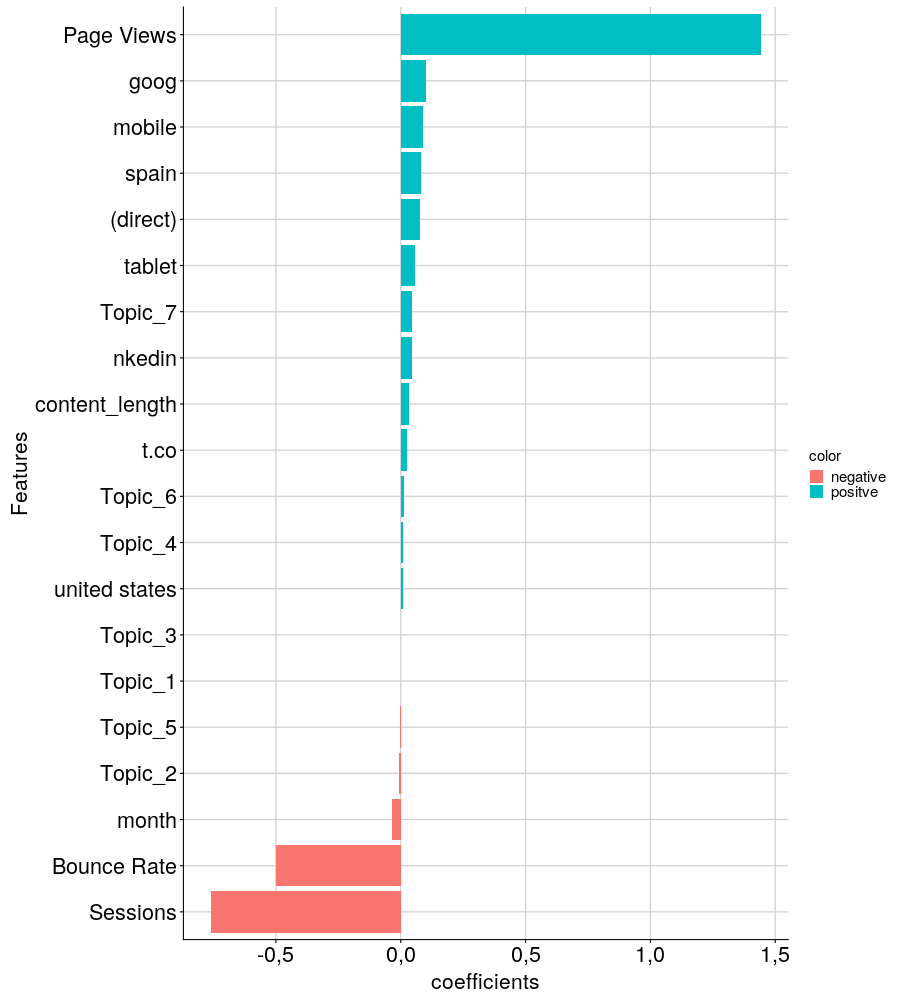

In [63]:
%%R -i coef -w 900 -h 1000 -u px

dt.values = as.data.table(cbind(row.names(coef), coef), row.names = NULL)
names(dt.values) = c('Var1', 'value')
dt.values = dt.values[order(value, decreasing = T),]
dt.values = dt.values %>% mutate(color = ifelse(value <= 0,  'negative', 'positve'))

d <- ggplot(dt.values, aes(y = value, x = reorder(Var1, value), fill = color)) +  geom_bar(stat = "identity") + coord_flip()
d <- d + ylab('coefficients') + xlab('Features') 
  #d <- d +  theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(1.5)))
d <- d + theme(axis.text.y = element_text(size = rel(1.8)))
d <- d + theme(axis.text.x = element_text(size = rel(1.8)))
d <- d + theme(axis.title.x = element_text(size = rel(1.5)))
d <- d + theme(legend.text = element_text(size = 15))
d <- d + theme(legend.title = element_text(size = 15))
d <- d +  theme(
    panel.background = element_rect(fill="white") ,
    panel.grid.minor.y = element_line(size=3),
    panel.grid.major = element_line(colour = "lightgray"),
    plot.background = element_rect(fill="white")
  )

ggsave('fig/svm_importance.png')
d

In [64]:
svm_percent, svm_mae, svm_mse = error_comparison(y1_svm, y_Train, method = 'SVM', data_t = 'training')

training error = 496385.0457856024 mae in SVMRegression
training error = 33535897.112619884 rmse in SVMRegression


In [65]:
t_svm_percent, t_svm_mae, t_svm_mse = error_comparison(y2_svm, Y_test, method = 'SVM', data_t = 'test')

test error = 372699406.29853463 mae in SVMRegression
test error = 16550487995.906395 rmse in SVMRegression


[[1.         0.19879094]
 [0.19879094 1.        ]]


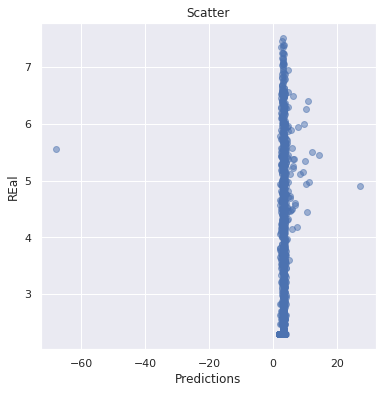

In [66]:
print(np.corrcoef(y2_svm, Y_test))
# Plot
plt.scatter(y2_svm, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Residual plot in SVM')

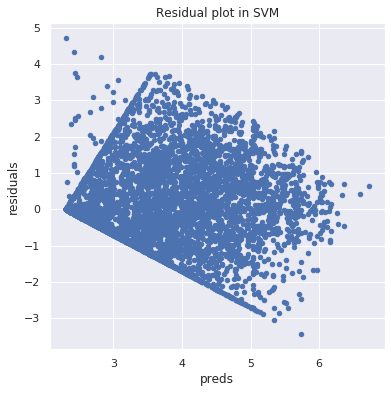

In [67]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)
preds = pd.DataFrame({"preds":knn.predict(x_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")
plt.title("Residual plot in SVM")

## **xgboost**

In [68]:
import xgboost as xgb

In [69]:
# RANDON SEARCH

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {
        'silent': [False],
        'max_depth': [6, 10, 15, 20],
        'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'colsample_bylevel': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
        'gamma': [0, 0.25, 0.5, 1.0],
        'reg_lambda': [0.1, 1.0, 5.0, 10.0, 50.0, 100.0],
        'n_estimators': [100]}

xb = xgb.XGBRegressor(objective ='reg:squarederror')
xgb_cv = RandomizedSearchCV(xb, param_dist, cv=10)
X = xgb_cv.fit(x_train,y_train)

-- Random Parameter Search via 10-fold CV


In [70]:
print(xgb_cv.best_score_)
print(xgb_cv.best_params_)
print(xgb_cv.best_estimator_)

0.5449934419266069
{'subsample': 0.7, 'silent': False, 'reg_lambda': 50.0, 'n_estimators': 100, 'min_child_weight': 7.0, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.25, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.25,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=7.0, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=50.0, scale_pos_weight=1,
             seed=None, silent=False, subsample=0.7, verbosity=1)


In [71]:

#data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror',subsample = 0.8, 
                          silent = False, reg_lambda = 50.0, n_estimators = 100, 
                          min_child_weight = 5.0, max_depth = 10, learning_rate = 0.1, 
                          gamma = 1.0, colsample_bytree = 0.7, colsample_bylevel = 0.8)

xg_reg.fit(x_train,y_train)
y1_xg = xg_reg.predict(x_train)
y2_xg = xg_reg.predict(x_test)

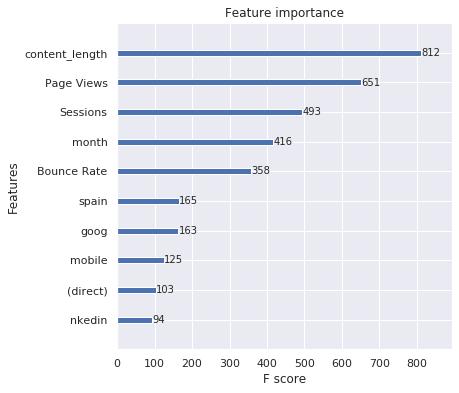

In [72]:
from xgboost import plot_importance
plot_importance(xg_reg, max_num_features=10) # top 10 most important features

## **ERRORS**

In [73]:
xgb_percent, xgb_mae, xgb_mse = error_comparison(y1_xg, y_Train, method = 'xgb', data_t = 'training')
t_xgb_percent, t_xgb_mae, t_xgb_mse = error_comparison(y2_xg, Y_test, method = 'xgb', data_t = 'test')

training error = 66.7825009474648 mae in xgbRegression
training error = 195.34254381869803 rmse in xgbRegression
test error = 64.47787908511519 mae in xgbRegression
test error = 184.57851121347775 rmse in xgbRegression


[[1.        0.7383967]
 [0.7383967 1.       ]]


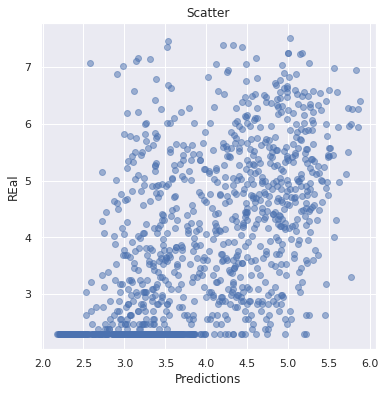

In [74]:
print(np.corrcoef(y2_xg, Y_test))
# Plot
plt.scatter(y2_xg, Y_test, alpha=0.5)
plt.title('Scatter')
plt.xlabel('Predictions')
plt.ylabel('REal')
plt.show()

## **KERAS**

In [75]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [76]:
'''
def baseline_model():
    model = Sequential()
    model.add(Dense(53, input_dim=len(x_train.columns), kernel_initializer='normal', 
        activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mse']) #adam sgd mae
    return model
seed = 1
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)
kfold = KFold(n_splits=10, random_state=seed)

results = cross_val_score(estimator,  x_train, y_train,  cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
'''

'\ndef baseline_model():\n    model = Sequential()\n    model.add(Dense(53, input_dim=len(x_train.columns), kernel_initializer=\'normal\', \n        activation=\'relu\'))\n    model.add(Dense(6, kernel_initializer=\'normal\', activation=\'relu\'))\n    model.add(Dense(1, kernel_initializer=\'normal\'))\n    model.compile(loss=\'mean_squared_error\', optimizer=\'adam\', metrics= [\'mse\']) #adam sgd mae\n    return model\nseed = 1\nestimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=False)\nkfold = KFold(n_splits=10, random_state=seed)\n\nresults = cross_val_score(estimator,  x_train, y_train,  cv=kfold)\nprint("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))\n'

In [77]:
seed = 1
def baseline_model():
    model = Sequential()
    model.add(Dense(23, input_dim=len(x_train.columns), kernel_initializer='normal', 
        activation='relu'))
    #model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics= ['mse']) #adam sgd mae
    return model

In [78]:
# Evaluate model using standardized dataset. 
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5, shuffle=True, random_state=seed) #10
results = cross_val_score(pipeline, x_train, y_train, cv=kfold)
#print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

In [79]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('standardize',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('mlp',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7f369e039ed0>)],
         verbose=False)

In [80]:
predict_train = pd.DataFrame(pipeline.predict(x_train))
predict_test = pd.DataFrame(pipeline.predict(x_test))

In [82]:
dl_percent, dl_mae, dl_mse = error_comparison(list(predict_train[0]), y_Train, method = 'deeplearning', data_t = 'training')
t_dl_percent, t_dl_mae, t_dl_mse = error_comparison(list(predict_test[0]), Y_test, method = 'deeplearning', data_t = 'test')

training error = 72.15244719131337 mae in deeplearningRegression
training error = 203.06065984756094 rmse in deeplearningRegression
test error = 66.47316929230085 mae in deeplearningRegression
test error = 187.81010652873468 rmse in deeplearningRegression


## **COMPARISONS**

In [83]:
# results from h20: notebook 4_prediction_H20
H20_mae   = 67.72660850557324
t_H20_mae = 67.61272952085284
H20_mse   = 197.06747717226975
t_H20_mse = 191.65899203286992

In [84]:
from pandas import DataFrame,Series

train_error= [ridge_mae, knn_mae, dl_mae, dt_mae, xgb_mae, H20_mae] # svm_mae,
test_error= [t_ridge_mae, t_knn_mae, t_dl_mae, t_dt_mae,  t_xgb_mae, t_H20_mae] #t_svm_mae,

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Deep learning','Decision Tree', 'xgb', 'h20'] #'SVM',
df_error=DataFrame(data=col,index=models)
df_error


Train Error  Test Error
Ridge Regression    86.192111   88.331470
Knn                 69.366999   71.587986
Deep learning       72.152447   66.473169
Decision Tree       79.719581   72.735983
xgb                 66.782501   64.477879
h20                 67.726609   67.612730

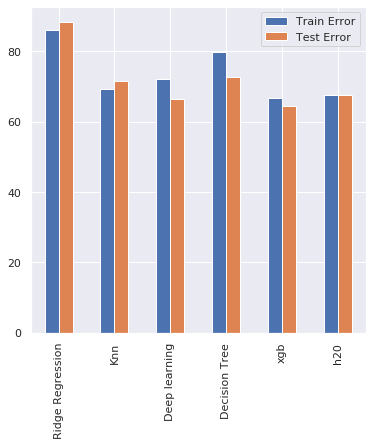

In [85]:
df_error.plot(kind='bar')

In [86]:
## RMSE
train_error= [ridge_mse, knn_mse, dl_mse, dt_mse,  xgb_mse, H20_mse] #svm_mse,
test_error= [t_ridge_mse, t_knn_mse, t_dl_mse, t_dt_mse, t_xgb_mse, t_H20_mse] # t_svm_mse,

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Knn','Deep learning','Decision Tree', 'xgb', 'h20'] #'SVM',
df_error=DataFrame(data=col,index=models)
df_error

Train Error  Test Error
Ridge Regression   243.023691  548.367073
Knn                196.220469  195.365630
Deep learning      203.060660  187.810107
Decision Tree      213.622722  198.269991
xgb                195.342544  184.578511
h20                197.067477  191.658992

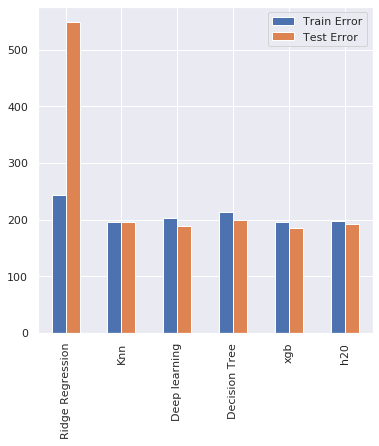

In [87]:
df_error.plot(kind='bar')